In [1]:
import gower, random, re, requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from kmodes.kprototypes import KPrototypes
from matplotlib import cm
from pyclustering.cluster.kmedoids import kmedoids
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler, normalize, StandardScaler
from time import sleep, time
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from tqdm.notebook import tqdm
import scipy.cluster.hierarchy as hc

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv('drive/MyDrive/Books_finalcleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33022 entries, 0 to 33021
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  33022 non-null  int64  
 1   Title       33022 non-null  object 
 2   Price_Old   33022 non-null  float64
 3   Discount    33022 non-null  float64
 4   Price_New   33022 non-null  float64
 5   Author      33022 non-null  object 
 6   Link        33022 non-null  object 
 7   Year        33022 non-null  int64  
 8   Category    33022 non-null  object 
 9   ISBN        33022 non-null  int64  
 10  Pages       33022 non-null  float64
 11  Binding     33022 non-null  object 
dtypes: float64(4), int64(3), object(5)
memory usage: 3.0+ MB


In [3]:
df.head()

,Unnamed: 0,Title,Price_Old,Discount,Price_New,Author,Link,Year,Category,ISBN,Pages,Binding
0,2,Οι 5 γλώσσες της αγάπης - 2η έκδοση,15.50,0.26,11.47,Gary Chapman,https://www.captainbook.gr/book/oi-5-glosses-t...,2016,['Αυτοβοήθεια'],9789604617005,240.0,Χαρτόδετο
1,3,Universo Gramatical Version…,27.75,0.11,24.70,María Jesús Blázquez Lozano,https://www.captainbook.gr/book/universo-grama...,2016,['Ισπανικά'],9788498484410,320.0,Μαλακό εξώφυλλο
2,5,MIRRORLESS PHOTOGRAPHY,15.00,0.10,13.50,Βαγγέλης Δελέγκος,https://www.captainbook.gr/book/mirrorless-pho...,2016,['Φωτογραφία'],9789608152236,164.0,Χαρτόδετο
3,6,Τριγυρνώ μες στην Αθήνα,12.00,0.11,10.68,Πέτρος Χριστούλιας,https://www.captainbook.gr/book/trigurno-mes-s...,2016,['Χόμπι'],9786185116224,80.0,Σκληρό εξώφυλλο
4,8,Θαυματουργά Μάντρας,22.00,0.10,19.80,Pandit Gopal Sharma,https://www.captainbook.gr/book/thaumatourga-m...,2016,"['Φιλοσοφία', 'Κοινωνιολογία', 'Θρησκεία']",9789604304264,208.0,Χαρτόδετο


In [4]:
print(set(df['Year']))

{2016, 2017, 2018, 2019, 2020}


In [5]:
len(set(df['Year']))

5

In [6]:
print(set(df['Category']))

{"['Προϊστορία']", "['Ψυχολογία', 'Ψυχανάλυση']", "['ΕφηβικήΛογοτεχνία']", "['ΕυρωπαϊκήΦιλοσοφία']", "['ΕναλλακτικέςΘεραπείες']", "['Μεταφυσική', 'Αποκρυφισμός']", "['Κρασί', 'Ποτό']", "['ΕλληνικήΕπανάσταση']", "['Εκπαίδευση', 'Παιδαγωγική']", "['Νουβέλα']", "['ΕλληνικήΠοίηση']", "['ΜεταφρασμένηΠοίηση']", "['Λεξικά&Εγκυκλοπαίδειες']", "['Παιδικά', 'Εφηβικά']", "['Ισπανικά']", "['Συνταγές']", "['Χάρτες', 'Οδηγοί', 'Ταξίδια']", "['ΓιαΜωρά']", "['Φυσική', 'Μαθηματικά']", "['Αθλητισμός']", "['Γερμανικά']", "['Μυθιστόρημα']", "['Ψυχιατρική']", "['ΕλληνικήΓλώσσα']", "['Μυθολογία']", "['Οικονομικά']", "['ΤαξιδιωτικοίΟδηγοί']", "['ΕλεύθεροςΧρόνος', 'Μαγειρική', 'Αθλητισμός']", "['Δοκίμια']", "['ΛατινικήΓραμματεία']", "['ΙσότηταΦύλων']", "['ΑρχαίαΕλληνικήΓραμματεία']", "['ΕκλαϊκευμένηΕπιστήμη']", "['ΤαξιδιωτικήΛογοτεχνία']", "['Δημοτικό']", "['Χριστιανισμός']", "['Δραστηριοτήτων', 'Διαδραστικά']", "['Χορός']", "['ΒυζαντινήΓραμματεία']", "['Σχέσεις', 'Γάμος', 'Οικογένεια']", "['Λύκειο']", "['Γλω

In [7]:
len(set(df['Category']))

88

In [8]:
print(set(df['Binding']))

{'Σετ προϊόντων σε κουτί', 'Σετ προιόντων σε κουτί', 'Σκληρόδετο', 'Βιβλίο', 'Παιδικό σε χοντρό χαρτόνι', 'Σετ προιόντων', 'Αφίσα', 'Διαστάσεις:', 'Καρφίτσα / Brochure', 'CD-Extra', 'Άδετο', 'Πανόδετο', 'Μαλακό Εξώφυλλο', 'Βιβλίο (άγνωστο δέσιμο)', 'Σπιράλ', 'Σκληρό εξώφυλλο', 'Παιδικό βιβλίο με αφρώδες εξώφυλλο', 'Βιβλίο άλλου δεσίματος', 'Χαρτόδετο', 'Μεγάλης διάστασης βιβλίο', 'Άγνωστο Δέσιμο', 'Κάρτες', 'EPUB', 'Σετ προιόντων σε σελοφάν κενού', 'Μαλακό εξώφυλλο', 'Ηχητικό σε CD', 'eBook', 'Αδιάβροχο βιβλίο', 'Ψηφιακή μεταφόρτωση', 'Καινοτόμο βιβλίο', 'Υφασμάτινο βιβλίο', 'Σετ προϊόντων', 'Δερματόδετο', 'Ημερολόγιο', 'Σπειροειδές', 'Αλμπουμ'}


In [9]:
len(set(df['Binding']))

36

In [10]:
df.nunique()

Unnamed: 0    11826
Title         31436
Price_Old      1278
Discount         36
Price_New      2109
Author        18744
Link          33022
Year              5
Category         88
ISBN          33003
Pages          1037
Binding          36
dtype: int64

In [11]:
data_meta = pd.DataFrame(df.nunique(), columns = ['num'], index = None).reset_index()
data_meta.columns = ['name', 'num']
data_meta['type'] = 'categorical'
data_meta

,name,num,type
0,Unnamed: 0,11826,categorical
1,Title,31436,categorical
2,Price_Old,1278,categorical
3,Discount,36,categorical
4,Price_New,2109,categorical
5,Author,18744,categorical
6,Link,33022,categorical
7,Year,5,categorical
8,Category,88,categorical
9,ISBN,33003,categorical


In [12]:
data_meta.loc[(~data_meta['name'].isin(['Binding', 'Category'])), 'type'] = 'numerical'
data_meta.loc[data_meta['name'].isin(['Author', 'Title', 'ISBN', 'Link']),'type'] = 'claim'
data_meta

,name,num,type
0,Unnamed: 0,11826,numerical
1,Title,31436,claim
2,Price_Old,1278,numerical
3,Discount,36,numerical
4,Price_New,2109,numerical
5,Author,18744,claim
6,Link,33022,claim
7,Year,5,numerical
8,Category,88,categorical
9,ISBN,33003,claim


In [13]:
categorical_features = list(data_meta.loc[data_meta['type'] == 'categorical', 'name'])
categorical_features

['Category', 'Binding']

In [14]:
numerical_features = list(data_meta.loc[data_meta['type'] == 'numerical', 'name'])
numerical_features

['Unnamed: 0', 'Price_Old', 'Discount', 'Price_New', 'Year', 'Pages']

In [15]:
df_new = df.drop(['Unnamed: 0', 'Author', 'Link', 'ISBN'], 1)
df_new.set_index('Title', inplace = True)
df_new

,Price_Old,Discount,Price_New,Year,Category,Pages,Binding
Title,,,,,,,
Οι 5 γλώσσες της αγάπης - 2η έκδοση,15.50,0.26,11.47,2016,['Αυτοβοήθεια'],240.0,Χαρτόδετο
Universo Gramatical Version…,27.75,0.11,24.70,2016,['Ισπανικά'],320.0,Μαλακό εξώφυλλο
MIRRORLESS PHOTOGRAPHY,15.00,0.10,13.50,2016,['Φωτογραφία'],164.0,Χαρτόδετο
Τριγυρνώ μες στην Αθήνα,12.00,0.11,10.68,2016,['Χόμπι'],80.0,Σκληρό εξώφυλλο
Θαυματουργά Μάντρας,22.00,0.10,19.80,2016,"['Φιλοσοφία', 'Κοινωνιολογία', 'Θρησκεία']",208.0,Χαρτόδετο
...,...,...,...,...,...,...,...
Φορολογικός οδηγός ναυτιλιακών…,75.00,0.11,66.75,2020,['Νομική'],635.0,Χαρτόδετο
Της ίριδας το πείσμα,8.89,0.11,7.91,2020,['Πεζογραφία'],80.0,Χαρτόδετο
Ταξιδεύοντας σε όλο τον κόσμο με…,12.72,0.11,11.32,2020,"['Εκπαίδευση', 'Παιδαγωγική']",34.0,Σκληρόδετο


In [16]:
attributes = pd.get_dummies(df_new)
attributes

,Price_Old,Discount,Price_New,Year,Pages,Category_['Αγγλικά'],Category_['Αθλητισμός'],Category_['ΑνατολικήΣκέψη'],Category_['Ανθρωπολογία'],Category_['ΑρχαίαΕλληνικήΓραμματεία'],Category_['ΑρχαίοιΈλληνεςΦιλόσοφοι'],Category_['Αρχιτεκτονική'],Category_['Αυτοβιογραφίες'],Category_['Αυτοβοήθεια'],Category_['Βιογραφίες'],Category_['Βυζάντιο'],Category_['ΒυζαντινήΓραμματεία'],Category_['Γαλλικά'],Category_['ΓενικάΛεξικά'],Category_['Γερμανικά'],Category_['ΓιαΜωρά'],Category_['Γλωσσολογία'],Category_['Γυμνάσιο'],Category_['Δημοτικό'],Category_['Διήγημα'],Category_['Διατροφή'],Category_['Δοκίμια'],"Category_['Δραστηριοτήτων', 'Διαδραστικά']",Category_['Εθνολογία'],Category_['ΕκλαϊκευμένηΕπιστήμη'],"Category_['Εκπαίδευση', 'Παιδαγωγική']","Category_['ΕλεύθεροςΧρόνος', 'Μαγειρική', 'Αθλητισμός']",Category_['ΕλληνικήΓλώσσα'],Category_['ΕλληνικήΕπανάσταση'],Category_['ΕλληνικήΠοίηση'],Category_['ΕναλλακτικέςΘεραπείες'],Category_['ΕργασιακέςΣχέσεις'],Category_['ΕυρωπαϊκήΦιλοσοφία'],Category_['ΕφηβικήΛογοτεχνία'],Category_['Ζωγραφική'],...,Category_['Χριστιανισμός'],Category_['Χόμπι'],Category_['Ψυχιατρική'],"Category_['Ψυχολογία', 'Ψυχανάλυση']",Binding_CD-Extra,Binding_EPUB,Binding_eBook,Binding_Άγνωστο Δέσιμο,Binding_Άδετο,Binding_Αδιάβροχο βιβλίο,Binding_Αλμπουμ,Binding_Αφίσα,Binding_Βιβλίο,Binding_Βιβλίο (άγνωστο δέσιμο),Binding_Βιβλίο άλλου δεσίματος,Binding_Δερματόδετο,Binding_Διαστάσεις:,Binding_Ημερολόγιο,Binding_Ηχητικό σε CD,Binding_Κάρτες,Binding_Καινοτόμο βιβλίο,Binding_Καρφίτσα / Brochure,Binding_Μαλακό Εξώφυλλο,Binding_Μαλακό εξώφυλλο,Binding_Μεγάλης διάστασης βιβλίο,Binding_Παιδικό βιβλίο με αφρώδες εξώφυλλο,Binding_Παιδικό σε χοντρό χαρτόνι,Binding_Πανόδετο,Binding_Σετ προιόντων,Binding_Σετ προιόντων σε κουτί,Binding_Σετ προιόντων σε σελοφάν κενού,Binding_Σετ προϊόντων,Binding_Σετ προϊόντων σε κουτί,Binding_Σκληρό εξώφυλλο,Binding_Σκληρόδετο,Binding_Σπειροειδές,Binding_Σπιράλ,Binding_Υφασμάτινο βιβλίο,Binding_Χαρτόδετο,Binding_Ψηφιακή μεταφόρτωση
Title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Οι 5 γλώσσες της αγάπης - 2η έκδοση,15.50,0.26,11.47,2016,240.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Universo Gramatical Version…,27.75,0.11,24.70,2016,320.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
MIRRORLESS PHOTOGRAPHY,15.00,0.10,13.50,2016,164.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Τριγυρνώ μες στην Αθήνα,12.00,0.11,10.68,2016,80.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Θαυματουργά Μάντρας,22.00,0.10,19.80,2016,208.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Φορολογικός οδηγός ναυτιλιακών…,75.00,0.11,66.75,2020,635.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Της ίριδας το πείσμα,8.89,0.11,7.91,2020,80.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Ταξιδεύοντας σε όλο τον κόσμο με…,12.72,0.11,11.32,2020,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,

In [17]:
sc = MinMaxScaler()
df_scaled = sc.fit_transform(attributes)
df_normalized = normalize(df_scaled)
pca = PCA(n_components = 3)
df_pca = pca.fit_transform(df_normalized)
df_pca = pd.DataFrame(df_pca)
df_pca.columns = ['P0', 'P1', 'P2']
df_pca

,P0,P1,P2
0,-0.436050,-0.044466,-0.207045
1,0.521970,-0.191277,-0.266642
2,-0.454448,-0.045797,-0.193845
3,0.056265,-0.190404,0.235272
4,-0.475441,-0.103881,-0.242237
...,...,...,...
33017,-0.377274,-0.180208,0.034530
33018,-0.382328,-0.211113,-0.018752
33019,0.046501,-0.346922,0.636748
33020,0.040158,-0.359975,0.552527


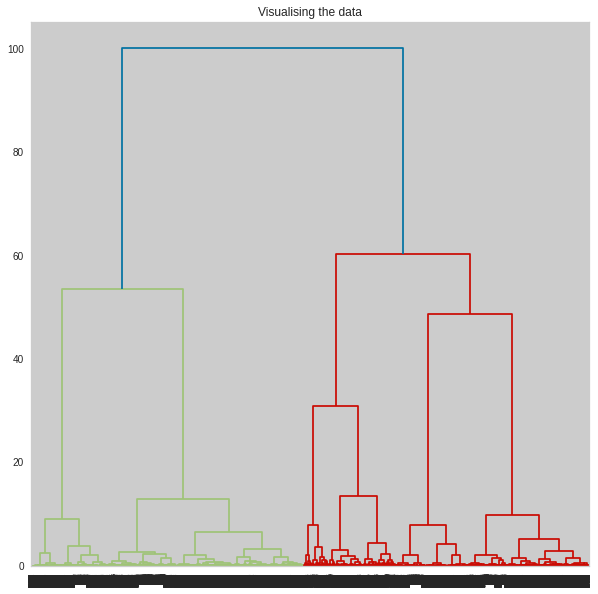

In [18]:
plt.figure(figsize = (10, 10))
plt.title('Visualising the data')
dendrogram = hc.dendrogram((hc.linkage(df_pca, method = 'ward')))

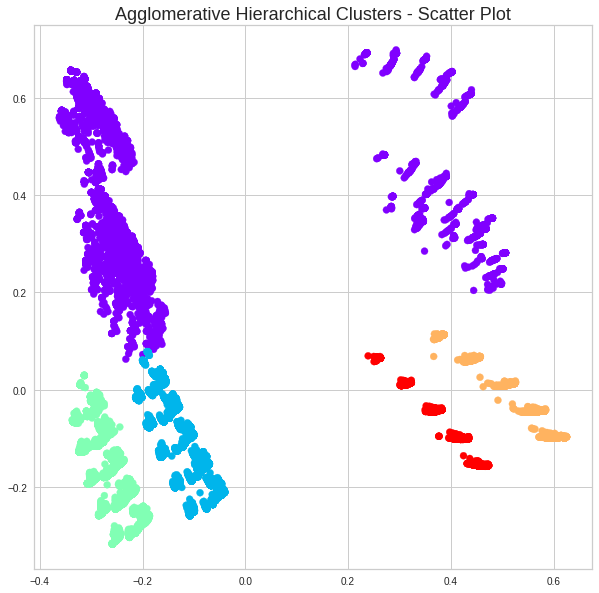

In [19]:
agc = AgglomerativeClustering(n_clusters = 5)
plt.figure(figsize = (10, 10))
plt.scatter(df_pca['P1'], df_pca['P2'], c = agc.fit_predict(df_pca), cmap = 'rainbow')
plt.title('Agglomerative Hierarchical Clusters - Scatter Plot', fontsize = 18)
plt.show()

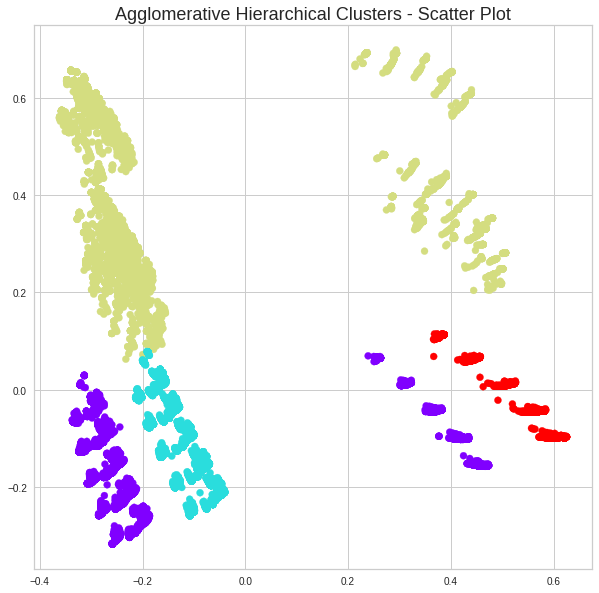

In [20]:
agc = AgglomerativeClustering(n_clusters = 4)
plt.figure(figsize = (10, 10))
plt.scatter(df_pca['P1'], df_pca['P2'], c = agc.fit_predict(df_pca), cmap ='rainbow')
plt.title('Agglomerative Hierarchical Clusters - Scatter Plot', fontsize = 18)
plt.show()

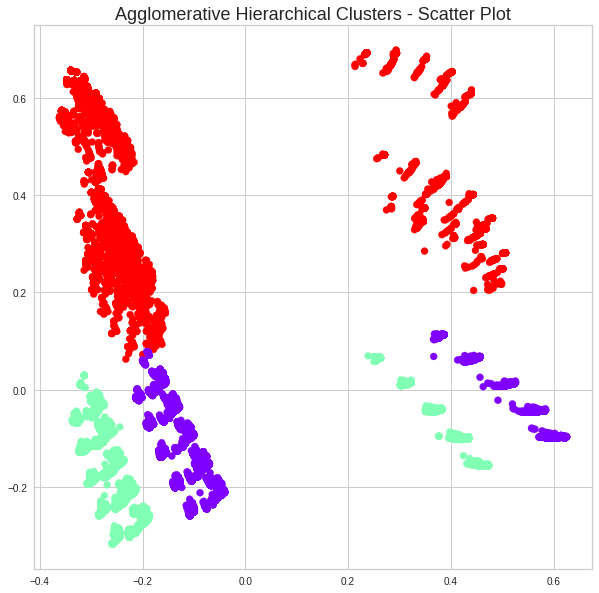

In [21]:
agc = AgglomerativeClustering(n_clusters = 3)
plt.figure(figsize = (10, 10))
plt.scatter(df_pca['P1'], df_pca['P2'], c = agc.fit_predict(df_pca), cmap = 'rainbow')
plt.title('Agglomerative Hierarchical Clusters - Scatter Plot', fontsize = 18)
plt.show()

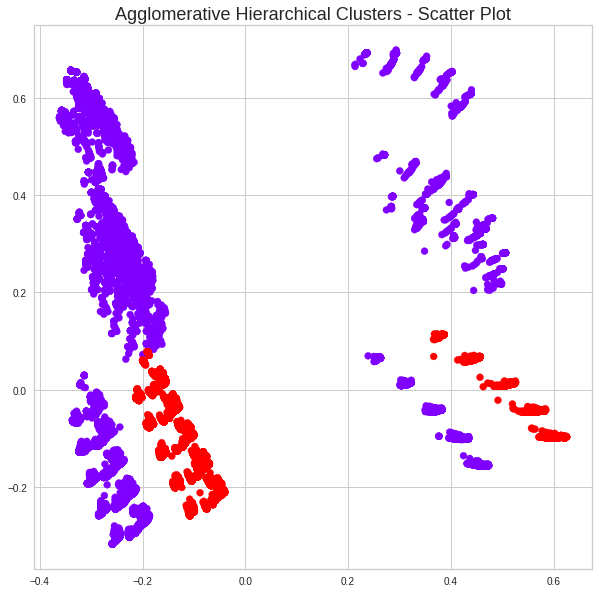

In [22]:
agc = AgglomerativeClustering(n_clusters = 2)
plt.figure(figsize =(10, 10))
plt.scatter(df_pca['P1'], df_pca['P2'], c = agc.fit_predict(df_pca), cmap = 'rainbow')
plt.title('Agglomerative Hierarchical Clusters - Scatter Plot', fontsize = 18)
plt.show()

AttributeError: ignored

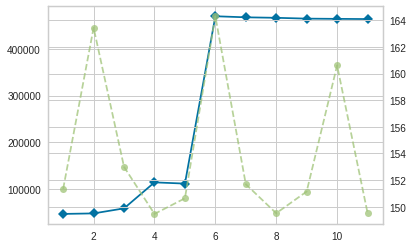

In [23]:
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k = (1, 12))
visualizer.fit(attributes)
visualizer.show()
None